### Algorithm Performance Experiment

In this notebook we implement the grid road environment simulating the cooperative package delivery problem, and compare the performance of A2C and PPO algorithms with existing implementations provided by _stable\_baselines3_ package.
The below _TL;DR Section Descriptions_ elaborates on the notebook implementation structure.

### TL;DR Section Descriptions

* [`Notebook Prerequisite Setup`](#notebook-prerequisite-setup): Installing `stable-baselines3` and related packages, plus defining all package imports
* [`Gym Environment Implementation`](#gym-environment-implementation): Implementing grid road environment variants, plus setting up Gym Monitor logger
* [`Reward Shaping Governance Layer Testing`](#reward-shaping-governance-layer-testing): Testing reward layer addition approach, and environment incorporation
* [`Governance Wrapper Layer Implementation`](#governance-wrapper-layer-implementation): Defining the dubbed Governance Wrapper layer onto grid delivery environments
* [`RL Algorithm Model Training`](#rl-algorithm-model-training): Training RL algorithms in simple CTCE setting for measuring approach efficacy, plus manually saving the log files locally

**Note:** From an implementation structure perspective it is very hard to coordinate changes in the util scripts and the notebooks on Colab servers. Therefore, all the utility functions and small sanity tests are also added into the presentation in this notebook itself. This decreases the readability to some extent but makes the execution, debugging, and replication very easier.

<a id='notebook-prerequisite-setup'></a>
#### 0. Notebook Prerequisite Setup

`In this section we first install stable-baselines3 and related packages required for Gym Monitor logging. And, then we import environment implementation, RL model training, and convergence plot related matplotlib packages.`

In [ ]:
# installing the latest stable-baselines3 library
# !pip install stable-baselines3
!pip install stable-baselines3
# ignoring the restart runtime instruction and continue with the cell execution

In [ ]:
# installing additional stable-baselines3 packages for plotting the agent learning outputs
# !pip install stable-baselines3
!pip install stable-baselines3[extra]
!apt install swig cmake
!pip install stable-baselines3[extra] box2d box2d-kengz
# ignoring the restart runtime instruction and continue with the cell execution

In [3]:
# OpenAI gym related import statements
# building a simpler environment that works with stablebaselines
import os
import gym
from gym import spaces
import numpy as np
import random

In [4]:
# learning curve plotting realted package imports
from gym.envs.registration import EnvSpec
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback

In [5]:
# import statements for 3D function plotting with matplotlib
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

<a id='gym-environment-implementation'></a>
#### 1. Gym Environment Implementation

This section implements five classes stated below for reference, and their _TL;DR Class Descriptions_ highlight functionalities of these classes at a functional level.
The inline comments explain the implementation functionalities in detail for all the described environment and logger classes.

#### TL;DR Class Descriptions

* `SaveOnBestTrainingRewardCallback`: It defines utility functions for saving the best model while learning based on Monitor wrapper's logged data.
* `SizeThreeSimpleGridRoadEnv`: This class defines the 3x3 grid environment with two agents where the second agent starts operating after the first agent movement completion. Every agent is having an associated gas parameter to intrinsically add a resource constraint setting.
* `SizeThreeGridRoadEnv`: This environment like previously is a 3x3 grid environment but while learning and testing during episodes it randomly rotates the configuration for testing model generalization abilities. Also, like the previous environment here the reward is only assigned when the package is completely delivered to the goal location.
* `SimpleGridRoadEnv`: This environment like SizeThreeSimpleGridRoadEnv is a fixed orientation environment but can define custom NxN configurations as inputs. Also, it attempts to scale the constrained gas resources accordingly having a basic problem convergence sanity check. Also, like previous environments when the agent hover over the package it automatically picks the package, and after finishing gas resources it automatically drops the package as well. When the package is picked, the agent will not be aware where the package is exactly, as the package location is visible on observation space but the agent needs to learn implicitly that the package has been picked.
* `GridRoadEnv`: This environment like SizeThreeGridRoadEnv is a random orientation environment which can define a custom NxN environment grid for our sparse reward problem. This is amongst the most complex forms of environment as new random configuration after each episode is hard to learn for RL models.

**Note:** Additionally, it would be infeasible to explain the workings of OpenAI gym and stable_baselines3 frameworks as part of the workflow comments in this notebook.
Please, refer to the documentation pages of these respective frameworks for getting more insights into environment implementation, adding environment wrappers, and implementing RL algorithms.


In [66]:
# utility class for saving the best model function
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
          # retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")
              # new best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)
        return True

# create log dir for the agent monitoring and result plotting
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

In [7]:
# the 3x3 road network environment doesn't rotate in its simple
# setting implementation
# implementation of the Simple 3x3 road network for MultiAgent RL
class SizeThreeSimpleGridRoadEnv(gym.Env):
    # Defining the Driving Agent with name and gas values plus package flag.
    class DriverAgent():
        def __init__(self, name, gas, package, picked):
            self.name = name
            self.gas = gas
            self.package = package
            self.picked = picked # flag, package has been picked once by the agent

    def __init__(self):
        # super(SizeThreeSimpleGridRoadEnv, self).__init__()
        # fefining different possible world configurations
        self.world_one = np.array([[1, 0, 0],
                      [3, 0, 2],
                      [0, 0, 4]])
        # self.world_two = np.rot90(self.world_one)
        # self.world_three = np.rot90(self.world_two)
        # self.world_four = np.rot90(self.world_three)
        # Eeen the initial world configuration is defined to be different upon
        # environment instantiation
        # prob = random.uniform(0, 1)
        # default value assignment below
        self.world = self.world_one
        # if prob > 0.25 and prob <= 0.25:
        #     self.world = self.world_two
        # elif prob > 0.5 and prob <= 0.75:
        #     self.world = self.world_three
        # elif prob > 0.75 and prob <= 1:
        #     self.world = self.world_four
        self.world_start = self.world # this 'world_start', if reset() is called, never gets used
        # adding five actions for the environment.
        # 0: up, 1: right, 2: down, 3: left,; 4: stay/pass chance,
        # 5: drop -> for agent learning simplicity eliminating 4 & 5 actions
        # when agent reaches at package location it automatically picks up the package
        self.action_space = spaces.Discrete(4)
        shape_0 = np.size(self.world_start, 0)
        shape_1 = np.size(self.world_start, 1)
        self.observation_space = spaces.Box(low=0,
                                            high=4,
                                            shape=(shape_0 + 1, shape_1),
                                            dtype=np.int16)
        self.reward_range = (-10, 10)
        self.current_episode = 0
        self.success_episode = []
        # defining the driver agents in the environment
        self.agent_one = self.DriverAgent(1,3,0,False) # 3 integer value, when carrying package
        self.agent_two = self.DriverAgent(2,8,0,False) # 3 integer value, when carrying package
        self.spec = EnvSpec("SizeThreeSimpleGridRoadEnv-v0")

    def reset(self):
        # sequential game like formulation, each player agent moves one step at a time
        # but resource specific delays are also added so that second agent waits for
        # first agent to finish it complete movement in the environment
        self.agent_one = self.DriverAgent(1,3,0,False) # instantiating agent 1 again
        self.agent_two = self.DriverAgent(2,4,0,False) # instantiating agent 2 again
        self.current_player = self.agent_one
        # 'P' means the game is playable, 'W' means delivered, 'L' means no delivery
        self.state = 'P'
        self.current_step = 0
        self.max_step = 32 # agent can choose not move as an alternate choice
        # selecting a world at random to function with
        # even the initial world configuration should be different
        # prob = random.uniform(0, 1)
        # if prob > 0.25 and prob <= 0.25:
        #     self.world_start = self.world_two
        # elif prob > 0.5 and prob <= 0.75:
        #     self.world_start = self.world_three
        # elif prob > 0.75 and prob <= 1:
        #     self.world_start = self.world_four
        # elif prob < 0.25:
        #     self.world_start = self.world_one
        self.world_start = self.world_one    
        self.world = np.copy(self.world_start) # the self.world can be different from intial world
        # no exploration_prize and bonus_reward as per the design
        return self._next_observation()
    
    def _next_observation(self):
        obs = self.world
        data_to_add = [0] * np.size(self.world, 1)
        data_to_add[0] = self.current_player.name # adding current player's label in the observation
        obs = np.append(obs, [data_to_add], axis=0)
        # observation sample provided below for reference:
        # last row, represents 'data_to_add' vector representing the current agent
        # array([[1, 0, 0],
        #         [3, 0, 2],
        #         [0, 0, 4],
        #         [1, 0, 0]])
        return obs

    def _take_action(self, action):
        # agent's name is matched to the array entries for index identification
        # 'current_player.name' should be updated alongside the array values
        current_pos = np.where(self.world == self.current_player.name)
        # the current agent must have gas in it
        if self.current_player.gas > 0:
            if action == 0:
                next_pos = (current_pos[0] - 1, current_pos[1]) # agent moving upwards

                if next_pos[0] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # two Agents can't be at the same place

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent
                    self.current_player.picked = True # package is picked once by the agent
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it.
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 1:
                next_pos = (current_pos[0], current_pos[1] + 1)
                limit = np.size(self.world, 1)

                if next_pos[1] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # two Agents can't be at the same place

                elif next_pos[1] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent
                    self.current_player.picked = True # package is picked once by the agent
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 2:
                next_pos = (current_pos[0] + 1, current_pos[1])
                limit = np.size(self.world, 0)

                if next_pos[0] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # two Agents can't be at the same place

                elif next_pos[0] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent
                    self.current_player.picked = True # package is picked once by the agent
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            elif action == 3:
                next_pos = (current_pos[0], current_pos[1] - 1)

                if next_pos[1] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # two Agents can't be at the same place

                elif next_pos[1] >= 0 and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent
                    self.current_player.picked = True # package is picked once by the agent
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            # removing functionality for action 4 and 5 for environment simplicity.
            # newly added logic based on new possible actions.
            # elif action == 4 and self.current_player.name != 1: # passing is allowed for agent 2 only
            #     pass # corresponding agent selects to not move at their chance
            
            # elif action == 5: # if agent is over the package, it has to pick it up, environment cases encoded above
            #     # agent can choose to drop the package, if it is loaded with it
            #     # after, dropping the package the agent should dissappear
            #     if self.current_player.package == 3:
            #         if self.world[current_pos] == 0:
            #             self.world[current_pos] = 3
            #             # agent dissappears from the grid after this drop
            #         elif self.world[current_pos] == 4: # added as extra case, functionally possibly won't be triggered
            #             self.world[current_pos] = self.current_player.name
            #             self.state = 'W'
            
        else:
            # player 1's gas is supposed to go empty first
            # therefore, upon having empty gas tank player should be allowed to
            # drop the package in the environment and disappear from the location
            if self.current_player.package == 3:
                self.world[current_pos] = self.current_player.package
                # self.current_player.picked = False # package is dropped by the agent
                # agent dissappears from the grid after this drop
            else:
                self.world[current_pos] = 0 # if gas is finished, agent should dissappear

        # if gas is empty for both agents, the episode should stop at that instant
        if self.agent_one.gas == 0 and self.agent_two.gas == 0:
            self.state = 'L'


    def step(self, action):
        self._take_action(action)
        self.current_step += 1
        # uncomment the below statement out, while debugging
        # print(self.world) 

        if self.state == "W":
            reward = 2.5
            done = True
        elif self.state == 'L':
            reward = 0
            done = True
        elif self.state == 'P':
            reward = 0 # sparse reward encoding, only rewarded when episode ends
            done = False

        if self.current_step >= self.max_step:
            print(f'New episode number {self.current_episode + 1}')
            done = True
        
        # removing functionality for alternate play for environment simplicity
        # agents object used to identify agent properties
        if self.current_player.name == 1 and self.current_step > 6: # general condition > (2*gas)
            self.current_player = self.agent_two
        elif self.current_player.name == 2:
            self.current_player = self.agent_one

        # adding functionality of sequential agent interaction for environment simplicity
        # if self.current_player.name == 1 and self.current_player.gas == 0:
        #     self.current_player = self.agent_two

        if done:
            self.render_episode(self.state)
            # self.reset()
            self.current_episode += 1
        
        # if done == True and self.state == 'L':
        #     self.reset()

        obs = self._next_observation()

        return obs, reward, done, {'state': self.state}, self.current_player

    def render_episode(self, win_or_lose):
        # storing the rendered episodes in a file
        self.success_episode.append(
            'Success' if win_or_lose == 'W' else 'Failure')
        file = open('render.txt', 'a')
        file.write('----------------------------\n')
        file.write(f'Episode number {self.current_episode}\n')
        file.write(
            f'{self.success_episode[-1]} in {self.current_step} steps\n')
        file.close()

In [8]:
# the 3x3 road network environment which rotate randomly in its simple
# setting implementation
# implementation of the Simple 3x3 road network for MultiAgent RL
class SizeThreeGridRoadEnv(gym.Env):
    # defining the Driving Agent with name and gas values plus package flag
    class DriverAgent():
        def __init__(self, name, gas, package, picked):
            self.name = name
            self.gas = gas
            self.package = package
            self.picked = picked # flag, package has been picked once by the agent

    def __init__(self):
        # super(SizeThreeSimpleGridRoadEnv, self).__init__()
        # defining different possible world configurations
        self.world_one = np.array([[1, 0, 0],
                      [3, 0, 2],
                      [0, 0, 4]])
        self.world_two = np.rot90(self.world_one)
        self.world_three = np.rot90(self.world_two)
        self.world_four = np.rot90(self.world_three)
        # even the initial world configuration is defined to be different upon
        # environment instantiation
        prob = random.uniform(0, 1)
        # default value assignment below
        self.world = self.world_one
        if prob > 0.25 and prob <= 0.25:
            self.world = self.world_two
        elif prob > 0.5 and prob <= 0.75:
            self.world = self.world_three
        elif prob > 0.75 and prob <= 1:
            self.world = self.world_four
        self.world_start = self.world # this 'world_start', if reset() is called, never gets used
        # adding five actions for the environment
        # 0: up, 1: right, 2: down, 3: left,; 4: stay/pass chance,
        # 5: drop -> for agent learning simplicity eliminating 4 & 5 actions
        # when agent reaches at package location it automatically picks up the package
        self.action_space = spaces.Discrete(4)
        shape_0 = np.size(self.world_start, 0)
        shape_1 = np.size(self.world_start, 1)
        self.observation_space = spaces.Box(low=0,
                                            high=4,
                                            shape=(shape_0 + 1, shape_1),
                                            dtype=np.int16)
        self.reward_range = (-10, 10)
        self.current_episode = 0
        self.success_episode = []
        # defining the driver agents in the environment
        self.agent_one = self.DriverAgent(1,3,0,False) # 3 integer value, when carrying package
        self.agent_two = self.DriverAgent(2,8,0,False) # 3 integer value, when carrying package
        self.spec = EnvSpec("SizeThreeGridRoadEnv-v0")

    def reset(self):
        # game like formulation, each player agent moves one step at a time
        self.agent_one = self.DriverAgent(1,3,0,False) # instantiating agent 1 again
        self.agent_two = self.DriverAgent(2,4,0,False) # instantiating agent 2 again
        self.current_player = self.agent_one
        # 'P' means the game is playable, 'W' means delivered, 'L' means no delivery
        self.state = 'P'
        self.current_step = 0
        self.max_step = 32 # agent can choose not move as an alternate choice
        # selecting a world at random to function with
        # even the initial world configuration should be different
        prob = random.uniform(0, 1)
        if prob > 0.25 and prob <= 0.25:
            self.world_start = self.world_two
        elif prob > 0.5 and prob <= 0.75:
            self.world_start = self.world_three
        elif prob > 0.75 and prob <= 1:
            self.world_start = self.world_four
        elif prob < 0.25:
            self.world_start = self.world_one
        self.world_start = self.world_one
        self.world = np.copy(self.world_start) # the self.world can be different from intial world
        # no exploration_prize and bonus_reward as per my design
        return self._next_observation()
    
    def _next_observation(self):
        obs = self.world
        data_to_add = [0] * np.size(self.world, 1)
        data_to_add[0] = self.current_player.name # adding current player's label in the observation
        obs = np.append(obs, [data_to_add], axis=0)
        # observation Sample provided below for reference:
        # last row, represents 'data_to_add' vector
        # array([[1, 0, 0],
        #         [3, 0, 2],
        #         [0, 0, 4],
        #         [1, 0, 0]])
        return obs

    def _take_action(self, action):
        # agent's name is matched to the array entries for index identification
        # 'current_player.name' should be updated alongside the array values
        current_pos = np.where(self.world == self.current_player.name)
        # the current agent must have gas in it
        if self.current_player.gas > 0:
            if action == 0:
                next_pos = (current_pos[0] - 1, current_pos[1]) # agent moving upwards

                if next_pos[0] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # two Agents can't be at the same place

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent
                    self.current_player.picked = True # package is picked once by the agent
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 1:
                next_pos = (current_pos[0], current_pos[1] + 1)
                limit = np.size(self.world, 1)

                if next_pos[1] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # two Agents can't be at the same place

                elif next_pos[1] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent
                    self.current_player.picked = True # package is picked once by the agent
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name # like 34 are already there, for example
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 2:
                next_pos = (current_pos[0] + 1, current_pos[1])
                limit = np.size(self.world, 0)

                if next_pos[0] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # two Agents can't be at the same place

                elif next_pos[0] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent
                    self.current_player.picked = True # package is picked once by the agent
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            elif action == 3:
                next_pos = (current_pos[0], current_pos[1] - 1)

                if next_pos[1] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # two Agents can't be at the same place

                elif next_pos[1] >= 0 and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent
                    self.current_player.picked = True # package is picked once by the agent
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            # removing functionality for action 4 and 5 for environment simplicity
            # newly added logic based on three new possible actions
            # elif action == 4 and self.current_player.name != 1: # passing is allowed for agent 2 only
            #     pass # corresponding agent selects to not move at their chance
            
            # elif action == 5: # if agent is over the package, it has to pick it up, environment cases encoded above
            #     # agent can choose to drop the package, if it is loaded with it
            #     # after, dropping the package the agent should dissappear
            #     if self.current_player.package == 3:
            #         if self.world[current_pos] == 0:
            #             self.world[current_pos] = 3
            #             # agent dissappears from the grid after this drop
            #         elif self.world[current_pos] == 4: # added as extra case, functionally possibly won't be triggered
            #             self.world[current_pos] = self.current_player.name
            #             self.state = 'W'
            
        else:
            # player 1's gas is supposed to go empty first
            # therefore, upon having empty gas tank player should be allowed to
            # drop the package in the environment and disappear from the location
            if self.current_player.package == 3:
                self.world[current_pos] = self.current_player.package
                # self.current_player.picked = False # package is dropped by the agent
                # agent dissappears from the grid after this drop
            else:
                self.world[current_pos] = 0 # if gas is finished, agent should dissappear

        # if gas is empty for both agents, the episode should stop at that instant
        if self.agent_one.gas == 0 and self.agent_two.gas == 0:
            self.state = 'L'


    def step(self, action):
        self._take_action(action)
        self.current_step += 1
        # uncomment the below statement out, while debugging
        # print(self.world) 

        if self.state == "W":
            reward = 2.5
            done = True
        elif self.state == 'L':
            reward = 0
            done = True
        elif self.state == 'P':
            reward = 0 # sparse reward encoding, only rewarded when episode ends
            done = False

        if self.current_step >= self.max_step:
            print(f'New episode number {self.current_episode + 1}')
            done = True
        
        # removing functionality for alternate play for environment simplicity
        # agents object used to identify agent properties
        if self.current_player.name == 1 and self.current_step > 6: # general condition > (2*gas)
            self.current_player = self.agent_two
        elif self.current_player.name == 2:
            self.current_player = self.agent_one

        # adding functionality of sequential agent interaction for environment simplicity
        # if self.current_player.name == 1 and self.current_player.gas == 0:
        #     self.current_player = self.agent_two

        if done:
            self.render_episode(self.state)
            # self.reset()
            self.current_episode += 1
        
        # if done == True and self.state == 'L':
        #     self.reset()

        obs = self._next_observation()

        return obs, reward, done, {'state': self.state}, self.current_player

    def render_episode(self, win_or_lose):
        # storing the rendered episodes in a file
        self.success_episode.append(
            'Success' if win_or_lose == 'W' else 'Failure')
        file = open('render.txt', 'a')
        file.write('----------------------------\n')
        file.write(f'Episode number {self.current_episode}\n')
        file.write(
            f'{self.success_episode[-1]} in {self.current_step} steps\n')
        file.close()

In [130]:
# the NxN road network environment doesn't rotate in its simple
# setting implementation
# implementation of the Simple NxN road network for MultiAgent RL
class SimpleGridRoadEnv(gym.Env):
    # defining the Driving Agent with name and gas values plus package flag
    class DriverAgent():
        def __init__(self, name, gas, package):
            self.name = name
            self.gas = gas
            self.package = package

    def __init__(self, size=5, gas=7):
        # size: grid size, gas: values restricted between (n_min: trunc(n/2), n_max: 2*(n-1)-1)
        # converting even size to nearest odd number
        self.size = size
        if size % 2 == 0:
            self.size = self.size+1
        # defining different possible world configurations
        self.world_one = np.zeros((self.size,self.size), dtype=int)
        # setting up env values for the numpy array
        self.world_one[0][0]=1
        self.world_one[self.size-1][self.size-1]=4
        self.world_one[self.size//2][self.size-1]=2
        self.world_one[self.size//2][0]=3
        self.world = self.world_one
        # if prob > 0.25 and prob <= 0.25:
        #     self.world = self.world_two
        # elif prob > 0.5 and prob <= 0.75:
        #     self.world = self.world_three
        # elif prob > 0.75 and prob <= 1:
        #     self.world = self.world_four
        self.world_start = self.world # this 'world_start', if reset() is called, never gets used
        # Adding five actions for the environment.
        # 0: up, 1: right, 2: down, 3: left, 4: stay/pass chance, 5: drop & dissappear
        # when agent reaches at package location it automatically picks up the package
        self.action_space = spaces.Discrete(4)
        shape_0 = np.size(self.world_start, 0)
        shape_1 = np.size(self.world_start, 1)
        self.observation_space = spaces.Box(low=0,
                                            high=4,
                                            shape=(shape_0 + 1, shape_1),
                                            dtype=np.int16)
        self.reward_range = (-10, 10)
        self.current_episode = 0
        self.success_episode = []
        # defining the driver agents in the environment
        self.gas = gas
        # truncating the gas to the desirable range for experimentation
        if (self.gas < self.size//2) or (self.gas > (2*(self.size-1)-1)):
            self.gas = random.randint(self.size//2, 2*(self.size-1))
        self.agent_one = self.DriverAgent(1,self.gas,0) # 3 integer value, when carrying package
        self.agent_two = self.DriverAgent(2,int(self.gas*3),0) # 3 integer value, when carrying package
        self.spec = EnvSpec("SimpleGridRoadEnv-v0")

    def reset(self):
        # game like formulation, each player agent moves one step at a time
        self.agent_one = self.DriverAgent(1,self.gas,0) # instantiating agent 1 again
        self.agent_two = self.DriverAgent(2,int(self.gas*3),0) # instantiating agent 2 again
        self.current_player = self.agent_one
        # 'P' means the game is playable, 'W' means delivered, 'L' means no delivery
        self.state = 'P'
        self.current_step = 0
        self.max_step = int(self.gas*5) # agent can choose not move as an alternate choice
        # selecting a world at random to function with
        # even the initial world configuration should be different
        # prob = random.uniform(0, 1)
        # if prob > 0.25 and prob <= 0.25:
        #     self.world_start = self.world_two
        # elif prob > 0.5 and prob <= 0.75:
        #     self.world_start = self.world_three
        # elif prob > 0.75 and prob <= 1:
        #     self.world_start = self.world_four
        # elif prob < 0.25:
        #     self.world_start = self.world_one
        self.world_start = self.world_one    
        self.world = np.copy(self.world_start) # the self.world can be different from intial world
        # no exploration_prize and bonus_reward as per my design
        return self._next_observation()
    
    def _next_observation(self):
        obs = self.world
        data_to_add = [0] * np.size(self.world, 1)
        data_to_add[0] = self.current_player.name # adding current player's label in the observation
        obs = np.append(obs, [data_to_add], axis=0)
        # observation Sample provided below for reference:
        # last row, represents 'data_to_add' vector
        # a 3x3 observation grid example for reference
        # array([[1, 0, 0],
        #         [3, 0, 2],
        #         [0, 0, 4],
        #         [1, 0, 0]])
        return obs

    def _take_action(self, action):
        # agent's name is matched to the array entries for index identification
        # 'current_player.name' should be updated alongside the array values
        current_pos = np.where(self.world == self.current_player.name)
        # the current agent must have gas in it
        if self.current_player.gas > 0:
            if action == 0:
                next_pos = (current_pos[0] - 1, current_pos[1]) # agent moving upwards

                if next_pos[0] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # two agents can't be at the same place

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 1:
                next_pos = (current_pos[0], current_pos[1] + 1)
                limit = np.size(self.world, 1)

                if next_pos[1] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # two Agents can't be at the same place

                elif next_pos[1] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent.
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1.
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 2:
                next_pos = (current_pos[0] + 1, current_pos[1])
                limit = np.size(self.world, 0)

                if next_pos[0] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # teducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # two Agents can't be at the same place

                elif next_pos[0] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            elif action == 3:
                next_pos = (current_pos[0], current_pos[1] - 1)

                if next_pos[1] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # two Agents can't be at the same place

                elif next_pos[1] >= 0 and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass
        else:
            # player 1's gas is supposed to go empty first
            # therefore, upon having empty gas tank player should be allowed to
            # drop the package in the environment and disappear from the location
            if self.current_player.package == 3:
                self.world[current_pos] = self.current_player.package
                # agent dissappears from the grid after this drop
            else:
                self.world[current_pos] = 0 # if gas is finished, agent should dissappear
        # if gas is empty for both agents, the episode should stop at that instant
        if self.agent_one.gas == 0 and self.agent_two.gas == 0:
            self.state = 'L'


    def step(self, action):
        self._take_action(action)
        self.current_step += 1
        # uncomment the below statement out, while debugging
        # print(self.world) 

        if self.state == "W":
            reward = 5.75
            done = True
        elif self.state == 'L':
            reward = 0
            done = True
        elif self.state == 'P':
            reward = 0 # sparse reward encoding, only rewarded when episode ends
            done = False

        if self.current_step >= self.max_step:
            print(f'New episode number {self.current_episode + 1}')
            done = True

        # agents object used to identify agent properties
        if self.current_player.name == 1 and self.current_step > self.gas*2:
            self.current_player = self.agent_two
        elif self.current_player.name == 2:
            self.current_player = self.agent_one

        if done:
            self.render_episode(self.state)
            self.current_episode += 1

        obs = self._next_observation()

        return obs, reward, done, {'state': self.state}, self.current_player

    def render_episode(self, win_or_lose):
        # storing the rendered episodes in a file
        self.success_episode.append(
            'Success' if win_or_lose == 'W' else 'Failure')
        file = open('render.txt', 'a')
        file.write('----------------------------\n')
        file.write(f'Episode number {self.current_episode}\n')
        file.write(
            f'{self.success_episode[-1]} in {self.current_step} steps\n')
        file.close()

In [129]:
# the NxN road network environment that rotates in its simple
# setting implementation.
# implementation of the Simple NxN road network for MultiAgent RL
class GridRoadEnv(gym.Env):
    # defining the Driving Agent with name and gas values plus package flag
    class DriverAgent():
        def __init__(self, name, gas, package):
            self.name = name
            self.gas = gas
            self.package = package

    def __init__(self, size=5, gas=7):
        # size: grid size, gas: values restricted between (n_min: trunc(n/2), n_max: 2*(n-1)-1)
        # converting even size to nearest odd number
        self.size = size
        if size % 2 == 0:
            self.size = self.size+1
        # defining different possible world configurations
        self.world_one = np.zeros((self.size,self.size), dtype=int)
        # setting up env values for the numpy array
        self.world_one[0][0]=1
        self.world_one[self.size-1][self.size-1]=4
        self.world_one[self.size//2][self.size-1]=2
        self.world_one[self.size//2][0]=3
        self.world = self.world_one

        self.world_two = np.rot90(self.world_one)
        self.world_three = np.rot90(self.world_two)
        self.world_four = np.rot90(self.world_three)
        # even the initial world configuration is defined to be different upon
        # environment instantiation
        prob = random.uniform(0, 1)
        # default value assignment below
        if prob > 0.25 and prob <= 0.25:
            self.world = self.world_two
        elif prob > 0.5 and prob <= 0.75:
            self.world = self.world_three
        elif prob > 0.75 and prob <= 1:
            self.world = self.world_four
        self.world_start = self.world # this 'world_start', if reset() is called, never gets used
        # adding five actions for the environment
        # 0: up, 1: right, 2: down, 3: left
        # when agent reaches at package location it automatically picks up the package
        self.action_space = spaces.Discrete(4)
        shape_0 = np.size(self.world_start, 0)
        shape_1 = np.size(self.world_start, 1)
        self.observation_space = spaces.Box(low=0,
                                            high=4,
                                            shape=(shape_0 + 1, shape_1),
                                            dtype=np.int16)
        self.reward_range = (-10, 10)
        self.current_episode = 0
        self.success_episode = []
        # defining the driver agents in the environment
        self.gas = gas
        # truncating the gas to the desirable range for experimentation
        if (self.gas < self.size//2) or (self.gas > (2*(self.size-1)-1)):
            self.gas = random.randint(self.size//2, 2*(self.size-1))
        self.agent_one = self.DriverAgent(1,self.gas,0) # 3 integer value, when carrying package
        self.agent_two = self.DriverAgent(2,int(self.gas*3),0) # 3 integer value, when carrying package
        self.spec = EnvSpec("GridRoadEnv-v0")

    def reset(self):
        # game like formulation, each player agent moves one step at a time
        self.agent_one = self.DriverAgent(1,self.gas,0) # instantiating agent 1 again
        self.agent_two = self.DriverAgent(2,int(self.gas*3),0) # instantiating agent 2 again
        self.current_player = self.agent_one
        # 'P' means the game is playable, 'W' means delivered, 'L' means no delivery
        self.state = 'P'
        self.current_step = 0
        self.max_step = int(self.gas*5) # agent can choose not move as an alternate choice
        # selecting a world at random to function with
        # even the initial world configuration should be different
        prob = random.uniform(0, 1)
        if prob > 0.25 and prob <= 0.25:
            self.world_start = self.world_two
        elif prob > 0.5 and prob <= 0.75:
            self.world_start = self.world_three
        elif prob > 0.75 and prob <= 1:
            self.world_start = self.world_four
        elif prob < 0.25:
            self.world_start = self.world_one
        # self.world_start = self.world_one    
        self.world = np.copy(self.world_start) # the self.world can be different from intial world
        # no exploration_prize and bonus_reward as per my design
        return self._next_observation()
    
    def _next_observation(self):
        obs = self.world
        data_to_add = [0] * np.size(self.world, 1)
        data_to_add[0] = self.current_player.name # adding current player's label in the observation
        obs = np.append(obs, [data_to_add], axis=0)
        # observation Sample provided below for reference:
        # last row, represents 'data_to_add' vector
        # a 3x3 observation grid example for reference
        # array([[1, 0, 0],
        #         [3, 0, 2],
        #         [0, 0, 4],
        #         [1, 0, 0]])
        return obs

    def _take_action(self, action):
        # agent's name is matched to the array entries for index identification
        # 'current_player.name' should be updated alongside the array values
        current_pos = np.where(self.world == self.current_player.name)
        # the current agent must have gas in it
        if self.current_player.gas > 0:
            if action == 0:
                next_pos = (current_pos[0] - 1, current_pos[1]) # agent moving upwards

                if next_pos[0] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # two Agents can't be at the same place

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 1:
                next_pos = (current_pos[0], current_pos[1] + 1)
                limit = np.size(self.world, 1)

                if next_pos[1] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # two Agents can't be at the same place

                elif next_pos[1] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass


            elif action == 2:
                next_pos = (current_pos[0] + 1, current_pos[1])
                limit = np.size(self.world, 0)

                if next_pos[0] < limit and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos]) in (1, 2):
                    pass # two Agents can't be at the same place

                elif next_pos[0] < limit and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[0] < limit and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

            elif action == 3:
                next_pos = (current_pos[0], current_pos[1] - 1)

                if next_pos[1] >= 0 and int(self.world[next_pos]) == 0:
                    self.world[next_pos] = self.current_player.name
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos]) in (1, 2):
                    pass # two Agents can't be at the same place

                elif next_pos[1] >= 0 and (int(self.world[next_pos]) == 3):
                    self.world[next_pos] = self.current_player.name
                    self.current_player.package = 3 # package is also hidden now from other agent
                    self.world[current_pos] = 0
                    # reducing the agent's gas by 1
                    self.current_player.gas = self.current_player.gas - 1

                elif next_pos[1] >= 0 and int(self.world[next_pos] == 4):
                    # player should only be allowed this transition to this position
                    # when it is having the package with it
                    if self.current_player.package == 3:
                        self.world[next_pos] = self.current_player.name
                        self.world[current_pos] = 0
                        self.state = 'W' # and the episode, should end at that moment
                        # reducing the agent's gas by 1
                        self.current_player.gas = self.current_player.gas - 1
                    else:
                        pass

        else:
            # player 1's gas is supposed to go empty first
            # therefore, upon having empty gas tank player should be allowed to
            # drop the package in the environment and disappear from the location
            if self.current_player.package == 3:
                self.world[current_pos] = self.current_player.package
                # agent dissappears from the grid after this drop
            else:
                self.world[current_pos] = 0 # if gas is finished, agent should dissappear
        # if gas is empty for both agents, the episode should stop at that instant
        if self.agent_one.gas == 0 and self.agent_two.gas == 0:
            self.state = 'L'


    def step(self, action):
        self._take_action(action)
        self.current_step += 1
        # uncomment the below statement out, while debugging
        # print(self.world) 

        if self.state == "W":
            reward = 5.75
            done = True
        elif self.state == 'L':
            reward = 0
            done = True
        elif self.state == 'P':
            reward = 0 # sparse reward encoding, only rewarded when episode ends
            done = False

        if self.current_step >= self.max_step:
            print(f'New episode number {self.current_episode + 1}')
            done = True

        # agents object used to identify agent properties
        if self.current_player.name == 1 and self.current_step > self.gas*2:
            self.current_player = self.agent_two
        elif self.current_player.name == 2:
            self.current_player = self.agent_one

        if done:
            self.render_episode(self.state)
            self.current_episode += 1

        obs = self._next_observation()

        return obs, reward, done, {'state': self.state}, self.current_player

    def render_episode(self, win_or_lose):
        # storing the rendered episodes in a file
        self.success_episode.append(
            'Success' if win_or_lose == 'W' else 'Failure')
        file = open('render.txt', 'a')
        file.write('----------------------------\n')
        file.write(f'Episode number {self.current_episode}\n')
        file.write(
            f'{self.success_episode[-1]} in {self.current_step} steps\n')
        file.close()

<a id='reward-shaping-governance-layer-testing'></a>
#### 2. Reward Shaping Governance Layer Testing

The section below contains testing of reward shaping layer addition into the environment.
This effort first involves defining reward distribution kernel functions like `gradient_kernel` and `circular_kernel`, and then plotter functions that visualize these kernels in isolation and in superimposed manner.
Finally, we also test the `governance_reward` function which assigns specific rewards after the agent interaction transitions across the environment for both the agents.

In [ ]:
# utility function for governance kernel implementation
world_map_a = np.array([[1, 0, 0],
                      [3, 0, 2],
                      [0, 0, 4]])
# utility function for governance kernel implementation
world_map_b = np.array([[1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0],
                      [3, 0, 0, 0, 2],
                      [0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 4]])

# given the input world_map build a gradient reward distribution
def gradient_kernel(world_map):
    grad_kernel = np.zeros((world_map.shape[0], world_map.shape[1]))
    grad_unit = 0.01
    for i in range(0,world_map.shape[0]):
        for j in range(0,world_map.shape[1]):
            if i>=j:
               grad_kernel[i][j] = grad_unit*(i+j)
            else:
                grad_kernel[i][j] = grad_unit*(i-j)
    return grad_kernel
# testing gradient kernel function outputs
print('3x3 environment\'s gradient kernel')
print(gradient_kernel(world_map_a))
print('5x5 environment\'s gradient kernel')
print(gradient_kernel(world_map_b))

# similarly, building inverse squared reward distribution
def circular_kernel(world_map, agent_name):
    agent_ind_x, agent_ind_y = np.where(world_map == agent_name)
    grad_kernel = np.zeros((world_map.shape[0], world_map.shape[1]))
    grad_unit = 0.05
    # print(agent_ind_x, agent_ind_y)
    for i in range(0,world_map.shape[0]):
        for j in range(0,world_map.shape[1]):
            if i != agent_ind_x[0] and j != agent_ind_y[0]:
                grad_kernel[i][j] = 1/2*(grad_unit/(i-agent_ind_x[0])**2  +  grad_unit/(j-agent_ind_y[0])**2)
            elif i == agent_ind_x[0] and j != agent_ind_y[0]:
                grad_kernel[i][j] = grad_unit/(j-agent_ind_y[0])**2
            elif j == agent_ind_y[0] and i != agent_ind_x[0]:
                grad_kernel[i][j] = grad_unit/(i-agent_ind_x[0])**2
            elif i == agent_ind_x[0] and j == agent_ind_y[0]:
                grad_kernel[i][j] = 0
    return grad_kernel
# testing circular kernel function 
print('3x3 environment\'s circular kernel for agent 1')
print(circular_kernel(world_map_a, 1))
print('5x5 environment\'s circular kernel for agent 1')
print(circular_kernel(world_map_b, 1))
# testing circular kernel function
print('3x3 environment\'s circular kernel for agent 2')
print(circular_kernel(world_map_a, 2))
print('5x5 environment\'s circular kernel for agent 2')
print(circular_kernel(world_map_b, 2))

# superposition of governance kernels for generating the effective kernel output for both the agents
print('3x3 environment\'s superimposed kernel for agent 1')
print(np.add(gradient_kernel(world_map_a), circular_kernel(world_map_a, 1)))
print('5x5 environment\'s superimposed kernel for agent 1')
print(np.add(gradient_kernel(world_map_b), circular_kernel(world_map_b, 1)))
print('3x3 environment\'s superimposed kernel for agent 2')
print(np.add(gradient_kernel(world_map_a), circular_kernel(world_map_a, 2)))
print('5x5 environment\'s superimposed kernel for agent 2')
print(np.add(gradient_kernel(world_map_b), circular_kernel(world_map_b, 2)))

3x3 environment's gradient kernel
[[ 0.   -0.01 -0.02]
 [ 0.01  0.02 -0.01]
 [ 0.02  0.03  0.04]]
5x5 environment's gradient kernel
[[ 0.   -0.01 -0.02 -0.03 -0.04]
 [ 0.01  0.02 -0.01 -0.02 -0.03]
 [ 0.02  0.03  0.04 -0.01 -0.02]
 [ 0.03  0.04  0.05  0.06 -0.01]
 [ 0.04  0.05  0.06  0.07  0.08]]
3x3 environment's circular kernel for agent 1
[[0.      0.05    0.0125 ]
 [0.05    0.05    0.03125]
 [0.0125  0.03125 0.0125 ]]
5x5 environment's circular kernel for agent 1
[[0.         0.05       0.0125     0.00555556 0.003125  ]
 [0.05       0.05       0.03125    0.02777778 0.0265625 ]
 [0.0125     0.03125    0.0125     0.00902778 0.0078125 ]
 [0.00555556 0.02777778 0.00902778 0.00555556 0.00434028]
 [0.003125   0.0265625  0.0078125  0.00434028 0.003125  ]]
3x3 environment's circular kernel for agent 2
[[0.03125 0.05    0.05   ]
 [0.0125  0.05    0.     ]
 [0.03125 0.05    0.05   ]]
5x5 environment's circular kernel for agent 2
[[0.0078125  0.00902778 0.0125     0.03125    0.0125    ]
 [0.0

In [ ]:
def plot_kernel(kernel_value, title):
    x = range(kernel_value.shape[0])
    y = range(kernel_value.shape[1])
    # `plot_surface` expects `x` and `y` data to be 2D
    X, Y = np.meshgrid(x, y)
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, kernel_value, rstride=1, cstride=1, alpha=0.65, cmap=cm.coolwarm)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_zlim(np.min(kernel_value), np.max(kernel_value))
    ax.set_title(title)
    plt.show()

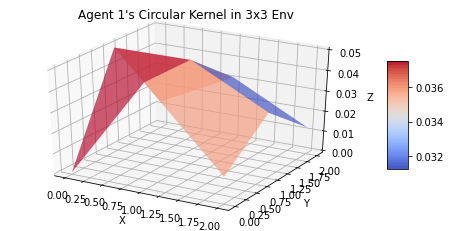

In [ ]:
# kernel function output plot
plot_kernel(circular_kernel(world_map_a, 1),'Agent 1\'s Circular Kernel in 3x3 Env')

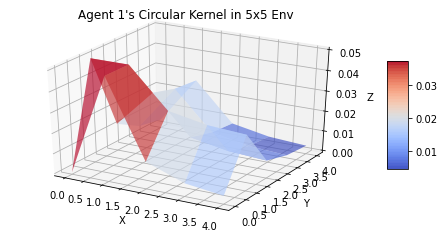

In [ ]:
# kernel function output plot
plot_kernel(circular_kernel(world_map_b, 1),'Agent 1\'s Circular Kernel in 5x5 Env')

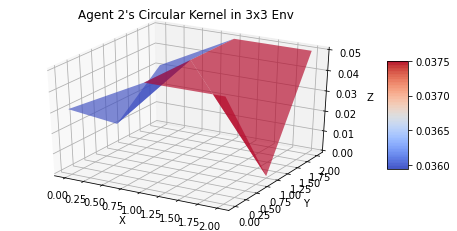

In [ ]:
# kernel function output plot
plot_kernel(circular_kernel(world_map_a, 2),'Agent 2\'s Circular Kernel in 3x3 Env')

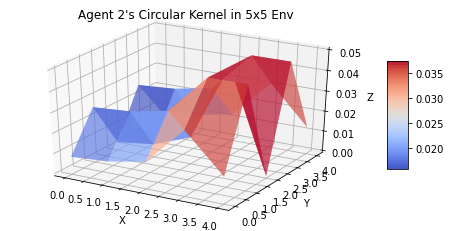

In [ ]:
# kernel function output plot
plot_kernel(circular_kernel(world_map_b, 2),'Agent 2\'s Circular Kernel in 5x5 Env')

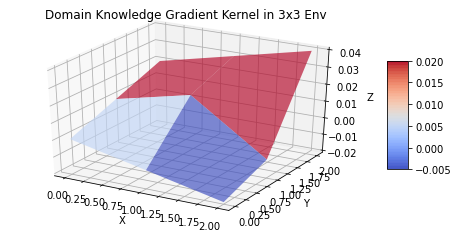

In [ ]:
# gradient kernel function output plot
plot_kernel(gradient_kernel(world_map_a),'Domain Knowledge Gradient Kernel in 3x3 Env')

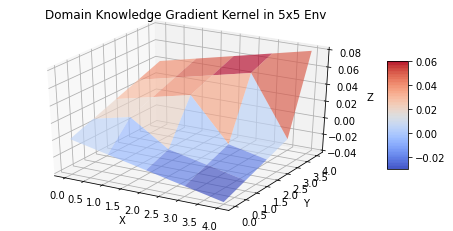

In [ ]:
# gradient kernel function output plot
plot_kernel(gradient_kernel(world_map_b),'Domain Knowledge Gradient Kernel in 5x5 Env')

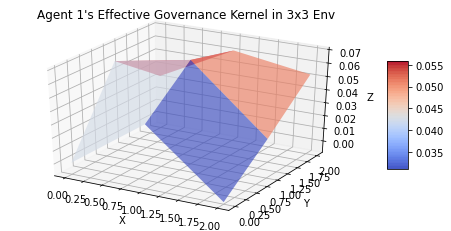

In [ ]:
# superimposed kernel function output plot
plot_kernel(np.add(gradient_kernel(world_map_a), circular_kernel(world_map_a, 1)),'Agent 1\'s Effective Governance Kernel in 3x3 Env')

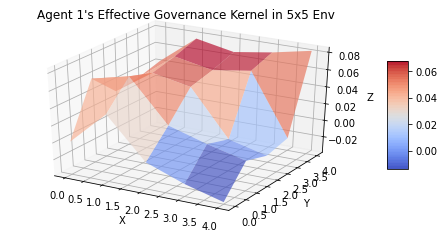

In [ ]:
# superimposed kernel function output plot
plot_kernel(np.add(gradient_kernel(world_map_b), circular_kernel(world_map_b, 1)),'Agent 1\'s Effective Governance Kernel in 5x5 Env')

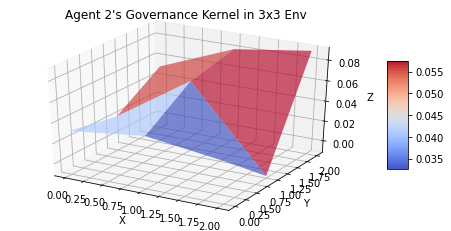

In [ ]:
# superimposed kernel function output plot
plot_kernel(np.add(gradient_kernel(world_map_a), circular_kernel(world_map_a, 2)),'Agent 2\'s Governance Kernel in 3x3 Env')

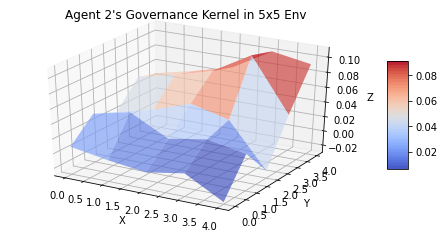

In [ ]:
# superimposed kernel function output plot
plot_kernel(np.add(gradient_kernel(world_map_b), circular_kernel(world_map_b, 2)),'Agent 2\'s Governance Kernel in 5x5 Env')

In [ ]:
# simualate some random interaction draws with the environment
import random
sample_obs_list = []
# GridRoadEnv, SizeThreeGridRoadEnv, SimpleGridRoadEnv, SizeThreeSimpleGridRoadEnv environments under testing
env_simple = SimpleGridRoadEnv()
# result_test = []
# obs = env_simple.reset()
for mul_ in range(5): # adding additional loop for more observations to
                      # observe reward shaping governance changes in better manner
    obs = env_simple.reset()
    sample_obs_ = []
    for i in range(200):
        action = random.randint(0, 4) # model_simple.predict(obs)
        obs, reward, done, info , agent = env_simple.step(action)
        # print(obs, reward, done, info, agent) # , agent.name, agent.gas, agent.package, agent.picked)
        # print('\n')
        sample_obs_.append(obs)
        if done:
            # print(info['state'])
            # obs = env_simple.reset()
            # result_test.append(info['state'])
            break
    sample_obs_list.append(sample_obs_)
print(len(sample_obs_list))
print(len(sample_obs_list[0]))
print(sample_obs_list[0][0])
# printing the output results w/ successful completions
# result_stat = result_test.count('W') / len(result_test)
# print(f'Success rate: {result_stat * 100} %')

New episode number 1
New episode number 2
New episode number 3
New episode number 4
New episode number 5
5
28
[[1 0 0 0 0]
 [0 0 0 0 0]
 [3 0 0 0 2]
 [0 0 0 0 0]
 [0 0 0 0 4]
 [1 0 0 0 0]]


In [ ]:
# implmenting two basic governance implementation variants, provided if first one succeeds
# 1. buildup of constant reward grid through out the delivery completion task
# 2. greedy delivery approach where already traversed nodes are reduced in reward distribution

# reward calculator utility function which uses agent's governance kernel
# and observation output to determine the new reward
# prev_obs = sample_obs_list[0][0]
def governance_reward(observation, kernel, agent_name, prev_obs):
    agent_ind_x, agent_ind_y = np.where(observation == agent_name)
    prev_agent_ind_x, prev_agent_ind_y = np.where(prev_obs == agent_name)
    prev_obs = observation # saving the previous observation state
    # if agent is not present in the observation grid, return 0 reward
    if agent_ind_x[0] >= kernel.shape[0] or agent_ind_y[0] >= kernel.shape[1]: 
        return 0, prev_obs
    # if agent is still at present at the previous grid position, return 0 reward
    if agent_ind_x[0] == prev_agent_ind_x[0] and agent_ind_y[0] == prev_agent_ind_y[0]: 
        return 0, prev_obs
    return kernel[agent_ind_x[0]][agent_ind_y[0]], prev_obs

gov_kern_agent_one = np.add(gradient_kernel(world_map_b), circular_kernel(world_map_b, 1))
gov_kern_agent_two = np.add(gradient_kernel(world_map_b), circular_kernel(world_map_b, 2))

for obs_list_ in sample_obs_list:
    prev_obs_agent_one = obs_list_[0]
    prev_obs_agent_two = obs_list_[0]
    for obs_ in obs_list_:
        if obs_[obs_.shape[0]-1][0] == 1:
            print(obs_, prev_obs_agent_one)
        else:
            print(obs_, prev_obs_agent_two)
        agent_name = obs_[obs_.shape[0]-1][0]
        print(agent_name)
        if agent_name == 1:
            reward, prev_obs_agent_one = governance_reward(obs_, gov_kern_agent_one, agent_name, prev_obs_agent_one)
            print(reward, prev_obs_agent_one)
        elif agent_name == 2:
            reward, prev_obs_agent_two =  governance_reward(obs_, gov_kern_agent_two, agent_name, prev_obs_agent_two)
            print(reward, prev_obs_agent_two)
        print('\n')
    print('End of episode observation states!')
# need to maintain previous observation state for each agent as well
# for removing the recurring reward return problem in the governed environment

<a id='governance-wrapper-layer-implementation'></a>
#### 3. Governance Wrapper Layer Implementation

The `SimpleGovernanceKernelWrapper` class inherits a specific environment, and adds reward distribution based wrapper functionalities to give dense reward signals during agent transitions.
Additionally, this layer also contains functionality to add in the directional governance component as well for better agent guidance and comparison with MORS baseline approach.
Second, the `GreedyGovernanceKernelWrapper` class functions in a similar manner except the reward distribution decreases as the agent traverses the environment.
The inline comments elaborates the functionalities of the implemented governance layer in more detail for more granular understanding of different components in the governance layer.

**Note:** The current design limits inheriting only a specific kind of class environment for a defined governance wrapper layer.
Therefore, for every experiment we have to replace and update the inherited parent environment class multiple times to carry out different experiments.

In [131]:
# basic conceptual framework of the Governance Wrapper:
# * environment prior information available, like initial agent positions and corresponding gas info.,
# * environment implementation needs change, agent info. or the whole agent instance needs to be returned as well
# * iterative radial reward value decrease by a factor of 5 from initial movement step from 0.25 up until {gas/dim} boundary
# * noise addition in the values, based on the grid size for size 3 noise factor zero, but with larger grid size, larger noise, for exploration promotion
# * partial task completion reward, 0.25 reward value attained upon package pickup by the agent
# * prior reward shaped grid based on basic environment information whill be matched with shared observation state for new reward calculation
# * additionally, create a simple reward shaping environment that only assigns 0.25 reward value upon package pickup by the agent

# environments available to inherit from:
# SizeThreeGridRoadEnv, SizeThreeSimpleGridRoadEnv, SimpleGridRoadEnv, GridRoadEnv
class SimpleGovernanceKernelWrapper(SizeThreeGridRoadEnv): 

    def governance_reward(self, observation, kernel, agent_name, prev_obs):
        agent_ind_x, agent_ind_y = np.where(observation == agent_name)
        prev_agent_ind_x, prev_agent_ind_y = np.where(prev_obs == agent_name)
        prev_obs = observation # saving the previous observation state
        # if agent is not present in the observation grid, return 0 reward
        if agent_ind_x[0] >= kernel.shape[0] or agent_ind_y[0] >= kernel.shape[1]: 
            return 0, prev_obs
        # if agent is still at present at the previous grid position, return 0 reward
        if agent_ind_x[0] == prev_agent_ind_x[0] and agent_ind_y[0] == prev_agent_ind_y[0]: 
            return 0, prev_obs
        return round(kernel[agent_ind_x[0]][agent_ind_y[0]],2), prev_obs

    def gradient_kernel(self, world_map):
        grad_kernel = np.zeros((world_map.shape[0], world_map.shape[1]))
        grad_unit = 0.025
        for i in range(0,world_map.shape[0]):
            for j in range(0,world_map.shape[1]):
                if i>=j:
                    grad_kernel[i][j] = grad_unit*(i+j)
                else:
                    grad_kernel[i][j] = grad_unit*(i-j)
        return grad_kernel

    def circular_kernel(self, world_map, agent_name):
        agent_ind_x, agent_ind_y = np.where(world_map == agent_name)
        grad_kernel = np.zeros((world_map.shape[0], world_map.shape[1]))
        grad_unit = 0.075
        # print(agent_ind_x, agent_ind_y)
        for i in range(0,world_map.shape[0]):
            for j in range(0,world_map.shape[1]):
                if i != agent_ind_x[0] and j != agent_ind_y[0]:
                    grad_kernel[i][j] = 1/2*(grad_unit/(i-agent_ind_x[0])**2  +  grad_unit/(j-agent_ind_y[0])**2)
                elif i == agent_ind_x[0] and j != agent_ind_y[0]:
                    grad_kernel[i][j] = grad_unit/(j-agent_ind_y[0])**2
                elif j == agent_ind_y[0] and i != agent_ind_x[0]:
                    grad_kernel[i][j] = grad_unit/(i-agent_ind_x[0])**2
                elif i == agent_ind_x[0] and j == agent_ind_y[0]:
                    grad_kernel[i][j] = 0
        return grad_kernel
    
    # superposition of governance kernels for generating the effective kernel output for both the agents
    # print(np.add(gradient_kernel(world_map), circular_kernel(world_map, 1)))
    # print(np.add(gradient_kernel(world_map), circular_kernel(world_map, 2)))

    def __init__(self, radial=False):
        super().__init__()
        self.prev_obs_agent_one = self.world_start
        self.prev_obs_agent_two = self.world_start
        self.radial_flag = radial
        if self.radial_flag == False:
            self.gov_kern_agent_one = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 1))
            self.gov_kern_agent_two = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 2))
        else:
            self.gov_kern_agent_one = self.circular_kernel(self.world_start, 1)
            self.gov_kern_agent_two = self.circular_kernel(self.world_start, 2)
        self.preward_flag_agent_one = True
        self.preward_flag_agent_two = True

    def reset(self):
        self.prev_obs_agent_one = self.world_start
        self.prev_obs_agent_two = self.world_start
        if self.radial_flag == False:
            self.gov_kern_agent_one = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 1))
            self.gov_kern_agent_two = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 2))
        else:
            self.gov_kern_agent_one = self.circular_kernel(self.world_start, 1)
            self.gov_kern_agent_two = self.circular_kernel(self.world_start, 2)
        self.preward_flag_agent_one = True
        self.preward_flag_agent_two = True
        return super().reset()

    def step(self, action):
        next_state, reward, done, info, agent = super().step(action)
        reward_new = 0
        if agent.name == 1:
            # print(next_state, self.prev_obs_agent_one)
            reward_new, self.prev_obs_agent_one = self.governance_reward(next_state, self.gov_kern_agent_one, agent.name, self.prev_obs_agent_one)
            # print(reward_new, self.prev_obs_agent_one, agent.name)
        elif agent.name == 2:
            # print(next_state, self.prev_obs_agent_two)
            reward_new, self.prev_obs_agent_two = self.governance_reward(next_state, self.gov_kern_agent_two, agent.name, self.prev_obs_agent_two)
            # print(reward_new, self.prev_obs_agent_two, agent.name)
        # print('\n')

        if agent.package == 3 and self.preward_flag_agent_one == True and agent.name == 1:
            reward_new = reward_new + 0.05
            self.preward_flag_agent_one = False
            # print(reward_new, agent.name)
        elif agent.package == 3 and self.preward_flag_agent_two == True and agent.name == 2:
            reward_new = reward_new + 0.05
            self.preward_flag_agent_two = False
            # print(reward_new, agent.name)

        reward_new  = round(reward_new, 2) + reward
        return next_state, reward_new, done, info # , agent
        #, agent; will give too values to unpack error for the default stablebaselines model implementation

# current checks, the reward shaping with kernel is working correctly,
# needs to add reward for successfully picking up the package as well

In [ ]:
# greedy governance implementation process:
# * 'governance_reward' function changes 'self.gov_kern_agent_one' & 'self.gov_kern_agent_one'
# * with probability epsilon, the select reward from the reward grid & reduce by given factor


# implementation process for random rotation models:
# kernel initialization should happen based on the newly initialized environment topology

# two governance alternative designs: baseline and greedy governance for experimentation

In [150]:
# basic conceptual framework of the Governance Wrapper:
# * environment prior information available, like initial agent positions and corresponding gas info.,
# * environment implementation needs change, agent info. or the whole agent instance needs to be returned as well
# * iterative radial reward value decrease by a factor of 5 from initial movement step from 0.25 up until {gas/dim} boundary
# * Noise addition in the values, based on the grid size for size 3 noise factor zero, but with larger grid size, larger noise, for exploration promotion
# * partial task completion reward, 0.25 reward value attained upon package pickup by the agent
# * prior reward shaped grid based on basic environment information whill be matched with shared observation state for new reward calculation
# * additionally, create a simple reward shaping environment that only assigns 0.25 reward value upon package pickup by the agent

# environments available to inherit from:
# SizeThreeGridRoadEnv, SizeThreeSimpleGridRoadEnv, SimpleGridRoadEnv, GridRoadEnv
class GreedyGovernanceKernelWrapper(SizeThreeGridRoadEnv):

    def governance_reward(self, observation, kernel, agent_name, prev_obs):
        agent_ind_x, agent_ind_y = np.where(observation == agent_name)
        prev_agent_ind_x, prev_agent_ind_y = np.where(prev_obs == agent_name)
        prev_obs = observation # saving the previous observation state
        # if agent is not present in the observation grid, return 0 reward
        if agent_ind_x[0] >= kernel.shape[0] or agent_ind_y[0] >= kernel.shape[1]: 
            return 0, prev_obs
        # if agent is still at present at the previous grid position, return 0 reward
        if agent_ind_x[0] == prev_agent_ind_x[0] and agent_ind_y[0] == prev_agent_ind_y[0]: 
            return 0, prev_obs

        kernel_reward_val = kernel[agent_ind_x[0]][agent_ind_y[0]] 

        if agent_name == 1:
            self.gov_kern_agent_one[agent_ind_x[0]][agent_ind_y[0]] = kernel[agent_ind_x[0]][agent_ind_y[0]] / 2
        if agent_name == 2:
            self.gov_kern_agent_two[agent_ind_x[0]][agent_ind_y[0]] = kernel[agent_ind_x[0]][agent_ind_y[0]] / 2

        
        return round(kernel_reward_val, 2), prev_obs

    def gradient_kernel(self, world_map):
        grad_kernel = np.zeros((world_map.shape[0], world_map.shape[1]))
        grad_unit = 0.01
        for i in range(0,world_map.shape[0]):
            for j in range(0,world_map.shape[1]):
                if i>=j:
                    grad_kernel[i][j] = grad_unit*(i+j)
                else:
                    grad_kernel[i][j] = grad_unit*(i-j)
        return grad_kernel

    def circular_kernel(self, world_map, agent_name):
        agent_ind_x, agent_ind_y = np.where(world_map == agent_name)
        grad_kernel = np.zeros((world_map.shape[0], world_map.shape[1]))
        grad_unit = 0.05
        # print(agent_ind_x, agent_ind_y)
        for i in range(0,world_map.shape[0]):
            for j in range(0,world_map.shape[1]):
                if i != agent_ind_x[0] and j != agent_ind_y[0]:
                    grad_kernel[i][j] = 1/2*(grad_unit/(i-agent_ind_x[0])**2  +  grad_unit/(j-agent_ind_y[0])**2)
                elif i == agent_ind_x[0] and j != agent_ind_y[0]:
                    grad_kernel[i][j] = grad_unit/(j-agent_ind_y[0])**2
                elif j == agent_ind_y[0] and i != agent_ind_x[0]:
                    grad_kernel[i][j] = grad_unit/(i-agent_ind_x[0])**2
                elif i == agent_ind_x[0] and j == agent_ind_y[0]:
                    grad_kernel[i][j] = 0
        return grad_kernel
    
    # superposition of governance kernels for generating the effective kernel output for both the agents
    # print(np.add(gradient_kernel(world_map), circular_kernel(world_map, 1)))
    # print(np.add(gradient_kernel(world_map), circular_kernel(world_map, 2)))

    def __init__(self, radial=False):
        super().__init__()
        self.prev_obs_agent_one = self.world_start
        self.prev_obs_agent_two = self.world_start
        self.radial_flag = radial
        if self.radial_flag == False:
            self.gov_kern_agent_one = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 1))
            self.gov_kern_agent_two = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 2))
        else:
            self.gov_kern_agent_one = self.circular_kernel(self.world_start, 1)
            self.gov_kern_agent_two = self.circular_kernel(self.world_start, 2)
        self.preward_flag_agent_one = True
        self.preward_flag_agent_two = True

    def reset(self):
        self.prev_obs_agent_one = self.world_start
        self.prev_obs_agent_two = self.world_start
        if self.radial_flag == False:
            self.gov_kern_agent_one = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 1))
            self.gov_kern_agent_two = np.add(self.gradient_kernel(self.world_start), self.circular_kernel(self.world_start, 2))
        else:
            self.gov_kern_agent_one = self.circular_kernel(self.world_start, 1)
            self.gov_kern_agent_two = self.circular_kernel(self.world_start, 2)
        self.preward_flag_agent_one = True
        self.preward_flag_agent_two = True
        return super().reset()

    def step(self, action):
        next_state, reward, done, info, agent = super().step(action)
        reward_new = 0
        if agent.name == 1:
            # print(next_state, self.prev_obs_agent_one)
            reward_new, self.prev_obs_agent_one = self.governance_reward(next_state, self.gov_kern_agent_one, agent.name, self.prev_obs_agent_one)
            # print(reward_new, self.prev_obs_agent_one, agent.name)
        elif agent.name == 2:
            # print(next_state, self.prev_obs_agent_two)
            reward_new, self.prev_obs_agent_two = self.governance_reward(next_state, self.gov_kern_agent_two, agent.name, self.prev_obs_agent_two)
            # print(reward_new, self.prev_obs_agent_two, agent.name)
        # print('\n')

        if agent.package == 3 and self.preward_flag_agent_one == True and agent.name == 1:
            reward_new = reward_new + 0.05
            self.preward_flag_agent_one = False
            # print(reward_new, agent.name)
        elif agent.package == 3 and self.preward_flag_agent_two == True and agent.name == 2:
            reward_new = reward_new + 0.05
            self.preward_flag_agent_two = False
            # print(reward_new, agent.name)

        reward_new  = round(reward_new, 2) + reward
        return next_state, reward_new, done, info # , agent
        #, agent; will give too values to unpack error for the default stablebaselines model implementation

# current checks, the reward shaping with kernel is working correctly,
# needs to add reward for successfully picking up the package as well

In [47]:
# storing obs data into simple road env for random walk testing for the environment
import random
simple_obs_list = []
simple_info_list = []
env_simple = GreedyGovernanceKernelWrapper(radial=False)
# result_test = []

for e_ in range(3):
    obs = env_simple.reset()
    for i in range(200):
        action = random.randint(0, 4) # model_simple.predict(obs)
        obs, reward, done, info = env_simple.step(action)
        # print(obs, reward, done, info) # , agent.name, agent.gas, agent.package, agent.picked)
        # print('\n')
        simple_obs_list.append(obs)
        simple_info_list.append(info)
        if done:
            print(info['state'])
            # obs = env_simple.reset()
            # result_test.append(info['state'])
            break
# printing the output results w/ successful completions
# result_stat = result_test.count('W') / len(result_test)
# print(f'Success rate: {result_stat * 100} %')

New episode number 1
P
New episode number 2
P
New episode number 3
P


<a id='rl-algorithm-model-training'></a>
#### 4. RL Algorithm Model Training

The `stable_baselines3` package implementation code for all the trained models as part of this experiment is presented in this section.
The naming convention of the trained model follows the specified order `{rl-algo}_model_{grid-size}_{orientation}`, and is uniquely defined for each of the experiment model variants.
Additionally, even though the `SimpleGovernanceKernelWrapper` and `GreedyGovernanceKernelWrapper` are the same for the models with incorporated governance layers, we manually change the inherited environment class before in the above governance layer section.

This section also defines basic plotter function to quickly observe the convergence plot, and get an idea about the initial model performance.
Also, we manually output the entire logging file generated by `Monitor` wrapper, and save it for further creating our experiment summaries in a more presentable manner.


In [49]:
# stable_baseline3 library related import statements
# from stable_baselines3.common.vec_env import DummyVecEnv # it's usage produces 'spec' related error
# from stable_baselines3.common.vec_env import SubprocVecEnv # it's usage produces 'spec' related error
from stable_baselines3 import A2C
from stable_baselines3 import PPO
# result plotter package function
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt

# important note: implementation limitation, currently both governance variants
# inherit specific environments during initialization & these wrappers are hard binded
# to the code. hence, need to be updated for manual experimentation with different environments

In [88]:
# ploting function utilities for smoothed moving average reward values
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=100)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " ")
    plt.show()

In [ ]:
# creating the environment for code compilation testing only
# env_simple = RewardShapedGridRoadEnv()
# logs will be saved in log_dir/monitor.csv
# env_simple = Monitor(env_simple, log_dir)

In [ ]:
env_simple = SimpleGovernanceKernelWrapper(radial=True)
# logs will be saved in log_dir/monitor.csv
env_simple = Monitor(env_simple, log_dir)
# training sample environment policy for checking the env functionality
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

ppo_model_3x3_simple = PPO("MlpPolicy", env_simple, verbose=0)
ppo_model_3x3_simple.learn(total_timesteps=75000, callback=callback)

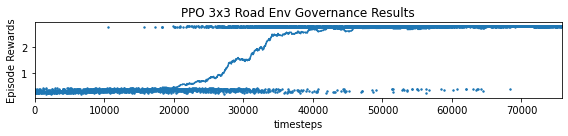

In [91]:
# helper function from the ploting library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO 3x3 Road Env Governance Results")

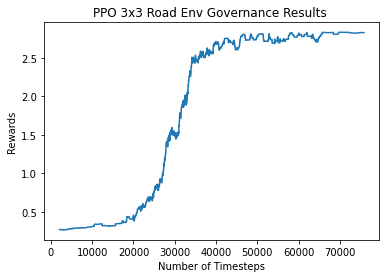

In [92]:
# reward function value curve
plot_results(log_dir, "PPO 3x3 Road Env Governance Results")

In [ ]:
# outputting the logged reward values
!cat /tmp/gym/monitor.csv

In [ ]:
env_simple = SimpleGovernanceKernelWrapper(radial=True)
# logs will be saved in log_dir/monitor.csv
env_simple = Monitor(env_simple, log_dir)
# training sample environment policy for checking the env functionality
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

a2c_model_3x3_simple = A2C("MlpPolicy", env_simple, verbose=0)
a2c_model_3x3_simple.learn(total_timesteps=75000, callback=callback)

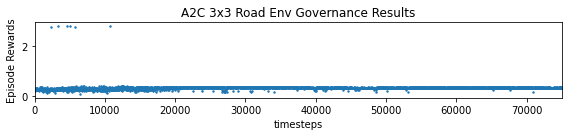

In [95]:
# helper function from the ploting library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "A2C 3x3 Road Env Governance Results")

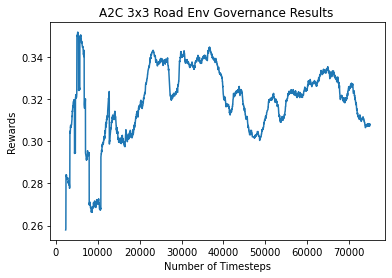

In [96]:
# reward function value curve
plot_results(log_dir, "A2C 3x3 Road Env Governance Results")

In [ ]:
# outputting the logged reward values
!cat /tmp/gym/monitor.csv

In [ ]:
env_random = SimpleGovernanceKernelWrapper(radial=True)
# logs will be saved in log_dir/monitor.csv
env_random = Monitor(env_random, log_dir)
# training sample environment policy for checking the env functionality
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

ppo_model_3x3_random = PPO("MlpPolicy", env_random, verbose=0)
ppo_model_3x3_random.learn(total_timesteps=75000, callback=callback)

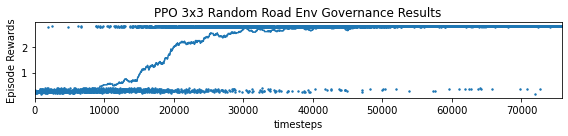

In [105]:
# helper function from the ploting library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO 3x3 Random Road Env Governance Results")

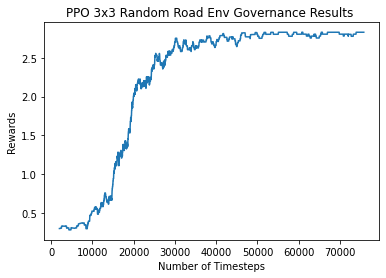

In [106]:
# reward function value curve
plot_results(log_dir, "PPO 3x3 Random Road Env Governance Results")

In [ ]:
# outputting the logged reward values
!cat /tmp/gym/monitor.csv

In [ ]:
env_random = SimpleGovernanceKernelWrapper(radial=True)
# logs will be saved in log_dir/monitor.csv
env_random = Monitor(env_random, log_dir)
# training sample environment policy for checking the env functionality
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

a2c_model_3x3_random = A2C("MlpPolicy", env_random, verbose=0)
a2c_model_3x3_random.learn(total_timesteps=75000, callback=callback)

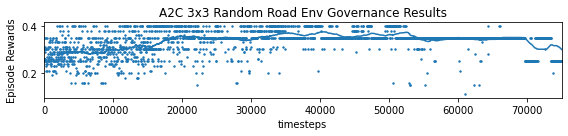

In [109]:
# helper function from the ploting library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "A2C 3x3 Random Road Env Governance Results")

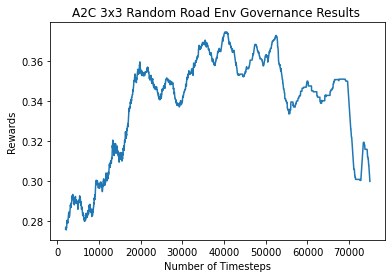

In [110]:
# reward function value curve
plot_results(log_dir, "A2C 3x3 Random Road Env Governance Results")

In [ ]:
# outputting the logged reward values
!cat /tmp/gym/monitor.csv

In [ ]:
env_simple = GreedyGovernanceKernelWrapper(radial=True)
# logs will be saved in log_dir/monitor.csv
env_simple = Monitor(env_simple, log_dir)
# training sample environment policy for checking the env functionality
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

ppo_model_3x3_greedy = PPO("MlpPolicy", env_simple, verbose=0)
ppo_model_3x3_greedy.learn(total_timesteps=75000, callback=callback)

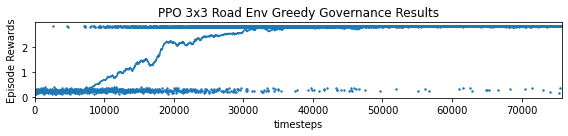

In [142]:
# helper function from the ploting library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO 3x3 Road Env Greedy Governance Results")

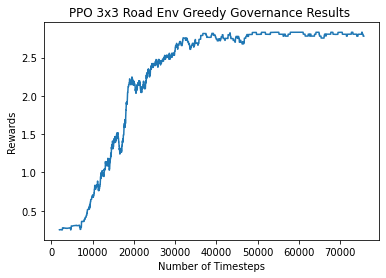

In [143]:
# reward function value curve
plot_results(log_dir, "PPO 3x3 Road Env Greedy Governance Results")

In [ ]:
# outputting the logged reward values
!cat /tmp/gym/monitor.csv

In [ ]:
env_simple = GreedyGovernanceKernelWrapper(radial=True)
# logs will be saved in log_dir/monitor.csv
env_simple = Monitor(env_simple, log_dir)
# training sample environment policy for checking the env functionality
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

a2c_model_3x3_greedy = A2C("MlpPolicy", env_simple, verbose=0)
a2c_model_3x3_greedy.learn(total_timesteps=75000, callback=callback)

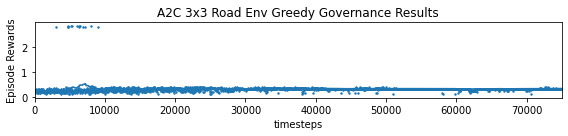

In [147]:
# helper function from the ploting library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "A2C 3x3 Road Env Greedy Governance Results")

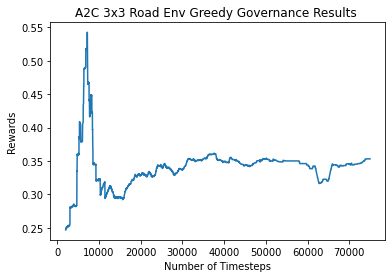

In [148]:
# reward function value curve
plot_results(log_dir, "A2C 3x3 Road Env Greedy Governance Results")

In [ ]:
# outputting the logged reward values
!cat /tmp/gym/monitor.csv

In [ ]:
env_random = GreedyGovernanceKernelWrapper(radial=True)
# logs will be saved in log_dir/monitor.csv
env_random = Monitor(env_random, log_dir)
# training sample environment policy for checking the env functionality
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

ppo_model_3x3_greedy_random = PPO("MlpPolicy", env_random, verbose=0)
ppo_model_3x3_greedy_random.learn(total_timesteps=75000, callback=callback)

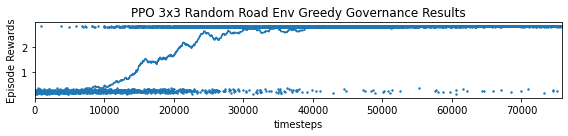

In [153]:
# helper function from the ploting library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO 3x3 Random Road Env Greedy Governance Results")

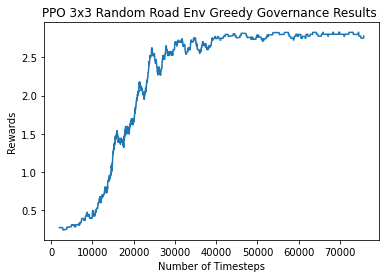

In [154]:
# reward function value curve
plot_results(log_dir, "PPO 3x3 Random Road Env Greedy Governance Results")

In [ ]:
# outputting the logged reward values
!cat /tmp/gym/monitor.csv

In [ ]:
env_random = GreedyGovernanceKernelWrapper(radial=True)
# logs will be saved in log_dir/monitor.csv
env_random = Monitor(env_random, log_dir)
# training sample environment policy for checking the env functionality
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

a2c_model_3x3_greedy_random = A2C("MlpPolicy", env_random, verbose=0)
a2c_model_3x3_greedy_random.learn(total_timesteps=75000, callback=callback)

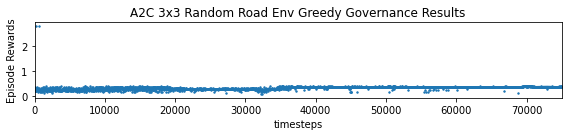

In [157]:
# helper function from the ploting library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "A2C 3x3 Random Road Env Greedy Governance Results")

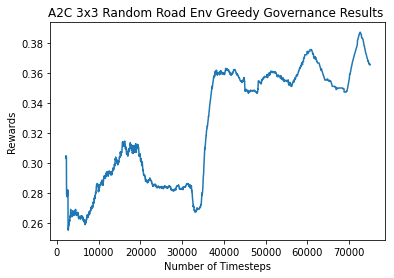

In [158]:
# reward function value curve
plot_results(log_dir, "A2C 3x3 Random Road Env Greedy Governance Results")

In [ ]:
# outputting the logged reward values
!cat /tmp/gym/monitor.csv